In [1]:
import gc
from collections import OrderedDict
from pathlib import Path
import time
import glob

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from pympler import asizeof
from tqdm.auto import tqdm

np.set_printoptions(precision=4, suppress=True)

print('tensorflow', tf.__version__)
print(tf.config.list_physical_devices('GPU'))

tensorflow 2.15.0-rc0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Define paths and functions

In [2]:
######### SELECT THE DATASET #########
# DATASET = 'Syncan'
DATASET = 'X-CANIDS'

DATASET_DIR = f"../../../Dataset/{DATASET}"

if DATASET == 'Syncan':
    data_files = {
        'train': [
            f'{DATASET_DIR}/train_train{i+1:02}.csv' for i in range(10)   # train_train01~10.csv
        ],
        'valid': [
            f'{DATASET_DIR}/train_valid.csv'
        ],
        'test': [
            f'{DATASET_DIR}/test_normal.csv',
            f'{DATASET_DIR}/test_flooding.csv',
            f'{DATASET_DIR}/test_plateau.csv',
            f'{DATASET_DIR}/test_continuous.csv',
            f'{DATASET_DIR}/test_playback.csv',
            f'{DATASET_DIR}/test_suppress.csv'
        ]
    }
elif DATASET == 'X-CANIDS':
    NSIG = '107'
    DATASET_DIR = f"../../../Dataset/{DATASET}"
    data_files = {
        'train': glob.glob(f'{DATASET_DIR}/canet/sig{NSIG}_dump[1-4].parquet'),
        'valid': [f'{DATASET_DIR}/canet/sig{NSIG}_dump5.parquet'],
        'test': glob.glob(f'{DATASET_DIR}/canet/sig{NSIG}_dump6-*.parquet')
    }

In [3]:
def load_arrange_data(file_path, dataset, print_option=True):
    if dataset == 'X-CANIDS':
        df = pd.read_parquet(file_path)
        df.reset_index(drop=True, inplace=True)
        df['ID'] = df['ID'].astype(str)
        if print_option:
            print(f'# rows: {df.shape[0]:,}')
            print(df['Session'].value_counts())
        return df
    elif dataset == 'Syncan':
        df = pd.read_csv(file_path, delimiter=',')
        df['Time'] = round(df['Time'] / 1000, 7)     # milliseconds to seconds
        df.rename(columns={'Label': 'Session'}, inplace=True)
        if print_option:
            print(f'# rows: {df.shape[0]:,}')
            print(df['Session'].value_counts())
        return df

def get_count_features(data_df: pd.DataFrame, window_size_s: int, start_s=0) -> pd.DataFrame:
    data_df = data_df[['Time', 'ID']].copy()
    data_df['occur'] = 1
    data_df = pd.concat([data_df['Time'], data_df.pivot(columns='ID', values='occur')], axis=1)
    data_df['TimeIndex'] = pd.to_timedelta(data_df['Time'], unit='s')
    data_df.set_index('TimeIndex', inplace=True)
    count_df = data_df.drop(columns=['Time']).rolling(str(window_size_s)+'s').count()
    count_df = count_df.astype('int16')
    assert len(data_df) == len(count_df)
    real_start_s = count_df.index.min().seconds
    real_start_us = count_df.index.min().microseconds
    count_df = count_df.loc[count_df.index > pd.Timedelta(seconds=real_start_s + start_s, microseconds=real_start_us)]
    return count_df

# Prepare input data

In [4]:
WINDOW_SIZE = 1
TRAIN_START = WINDOW_SIZE + 1

### Frequencies and number of signals of CAN IDs

In [5]:
if DATASET == 'Syncan':
    ID_MPS = {'id1': 67, 'id10': 22, 'id2': 33, 'id3': 67, 'id4': 22, 'id5': 67, 'id6': 33, 'id7': 67, 'id8': 67, 'id9': 33}
    ID_NSIG = OrderedDict([('id1', 2), ('id10', 4), ('id2', 3), ('id3', 2), ('id4', 1), ('id5', 2), ('id6', 2), ('id7', 2), ('id8', 1), ('id9', 1)])
elif DATASET == 'X-CANIDS':
    ID_MPS = {'1151': 50, '1265': 50, '128': 100, '129': 100, '1292': 10, '1322': 10, '1345': 11, '1349': 10, '1351': 10, '1353': 10, '1363': 5, '1365': 10, '1366': 10, '1367': 10, '1419': 10, '1427': 5, '1440': 1, '1456': 1, '273': 100, '274': 100, '275': 100, '354': 100, '399': 100, '512': 100, '544': 100, '593': 100, '608': 100, '68': 1, '688': 100, '790': 100, '809': 100, '897': 50, '899': 50, '902': 50, '903': 50}
    ID_NSIG = OrderedDict([('1151', 1), ('1265', 3), ('128', 5), ('129', 3), ('1292', 2), ('1322', 1), ('1345', 3), ('1349', 4), ('1351', 2), ('1353', 4), ('1363', 4), ('1365', 1), ('1366', 5), ('1367', 2), ('1419', 5), ('1427', 4), ('1440', 1), ('1456', 1), ('273', 4), ('274', 3), ('275', 4), ('354', 3), ('399', 3), ('512', 1), ('544', 4), ('593', 2), ('608', 5), ('68', 2), ('688', 2), ('790', 6), ('809', 6), ('897', 1), ('899', 2), ('902', 4), ('903', 4)])

### Data input pipeline functions
Each CAN ID will have the different length of time steps and number of signals

In [6]:
def get_repeated_sequences(data, can_id, n_sig, n_step, label=None):
    sig_columns = [f'Signal{i}' for i in range(1, n_sig + 1)]
    df_id = data.loc[data['ID'] == can_id, ['Idx', 'Session'] + sig_columns]
    np_sig = df_id[['Session'] + sig_columns].to_numpy()
    np_seq = np.lib.stride_tricks.sliding_window_view(np_sig, window_shape=n_step, axis=0)
    np_seq = np_seq.swapaxes(1, 2)
    if label=='sum':
        np_lab = np_seq[:, :, 0]
        np_lab = np_lab.max(axis=1)
    np_seq = np_seq[:, :, 1:]
    n_seq = np_seq.shape[0]
    end_idx = data['Idx'].iloc[-1]
    n_repeats = np.diff(df_id['Idx'].to_list() + [end_idx])[-n_seq:]
    repeated_seq = np.repeat(np_seq, n_repeats, axis=0)
    if label=='sum':
        repeated_lab = np.repeat(np_lab, n_repeats, axis=0)
        return repeated_seq, repeated_lab
    else:
        return repeated_seq  # An example of its shape: (344291, 50, 3)

def prepare_dataset(file_path, time_cutoff, label='last'):
    assert label in ['last', 'sum', False]
    data = load_arrange_data(file_path, dataset=DATASET, print_option=False)
    data = data.reset_index(names='Idx')
    time_start = data['Time'].iloc[0]
    n_rows_to_use = data.loc[data['Time'] > time_start + time_cutoff, 'Time'].shape[0]
    data_dict = dict()
    if label == 'last':
        time_and_labels = data.loc[data['Time'] > time_start + time_cutoff, ['Time', 'Session']].to_numpy()
        for id, nsig in ID_NSIG.items():
            seq_data = get_repeated_sequences(data, id, nsig, ID_MPS[id], label=label)
            data_dict[id] = seq_data[-n_rows_to_use:].copy()
    elif label == 'sum':
        lab_ids = []
        time_and_labels = data.loc[data['Time'] > time_start + time_cutoff, ['Time']].to_numpy()
        for id, nsig in ID_NSIG.items():
            seq_data, lab_data = get_repeated_sequences(data, id, nsig, ID_MPS[id], label=label)
            data_dict[id] = seq_data[-n_rows_to_use:].copy()
            lab_ids.append(lab_data[-n_rows_to_use:].copy())
        assert all([l == n_rows_to_use for l in map(len, lab_ids)])
        labels = np.max(lab_ids, axis=0).reshape(-1, 1)
        time_and_labels = np.concatenate([time_and_labels, labels], axis=1)
    if label:
        assert len(time_and_labels) == n_rows_to_use
        return data_dict, time_and_labels
    else:
        return data_dict

def load_inputs(data_path, time_cutoff, label, shuffle=True, seed=0):
    if not label:
        x_dict = prepare_dataset(data_path, time_cutoff=time_cutoff, label=False)
    else:
        x_dict, x_time_label = prepare_dataset(data_path, time_cutoff=time_cutoff, label=label)
    if shuffle:
        np.random.seed(seed)
        n_samples = len(x_dict[list(x_dict.keys())[0]])
        shuffled_idx = np.arange(n_samples)
        np.random.shuffle(shuffled_idx)
        x_dict = {id: seqs[shuffled_idx] for id, seqs in x_dict.items()}
        if label:
            x_time_label = x_time_label[shuffled_idx]
    y = np.concatenate([x_dict[id][:, -1, :] for id in FIXED_IDS], axis=1)
    if not label:
        return x_dict, y
    else:
        return x_dict, y, x_time_label

def label_to_bin(string_labels):
    assert len(string_labels.shape) == 1
    n_samples = len(string_labels)
    binary_labels = np.zeros(n_samples)
    binary_labels[string_labels != 'Normal'] = 1
    return binary_labels

# Create CANet model

In [7]:
N_SIGS = sum([n_sig for n_sig in ID_NSIG.values()])
FIXED_IDS = list(ID_NSIG.keys())
FIXED_IDS.sort()

def create_canet_model(h):
    inputs = {id: keras.Input(shape=(ID_MPS[id], ID_NSIG[id]), name=id) for id in FIXED_IDS}
    lstms = [keras.layers.LSTM(h * ID_NSIG[id], name=f'lstm_{id}') for id in FIXED_IDS]
    x_id = [lstms[i](inputs[id]) for i, id in enumerate(FIXED_IDS)]
    x = keras.layers.Concatenate()(x_id)
    x = keras.layers.Dense((h * N_SIGS) // 2, activation='elu')(x)
    x = keras.layers.Dense(N_SIGS - 1, activation='elu')(x)
    outputs = keras.layers.Dense(N_SIGS, activation='elu')(x)
    return keras.Model(inputs, outputs)

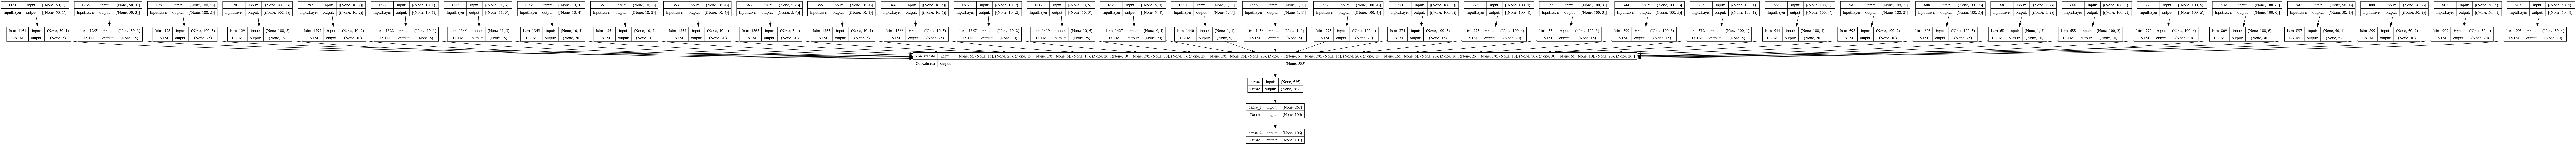

In [8]:
# Create the model
h = 5
model = create_canet_model(h)
keras.utils.plot_model(model, show_shapes=True)

# If X-CANIDS Dataset

### Save predictions of the chosenmodel

In [9]:
model.summary()
print(f'Model size: {asizeof.asizeof(model)/1024:.2f} KB')
print(f'# parameters: {model.count_params():,}')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 1151 (InputLayer)           [(None, 50, 1)]              0         []                            
                                                                                                  
 1265 (InputLayer)           [(None, 50, 3)]              0         []                            
                                                                                                  
 128 (InputLayer)            [(None, 100, 5)]             0         []                            
                                                                                                  
 129 (InputLayer)            [(None, 100, 3)]             0         []                            
                                                                                              

In [10]:
dt_experiment = '2024-06-30_19-10-20'
epoch = 10
weight_file = f'../../../models/CANET/{DATASET}_{dt_experiment}_epoch{epoch:02}'
model.load_weights(weight_file)
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)

In [11]:
def slice_data_for_canet(file_path: str, n_sliced: int):
    try:
        attack = Path(file_path).stem.split('-')[1]
    except IndexError:  # benign data
        attack = 'normal'
    df = pd.read_parquet(file_path)
    p = len(df) // n_sliced
    split_indices = list(range(0, len(df) + 1, p))[:-1]
    paths = []
    latest_msg = None
    assertion = False
    for i in range(n_sliced):
        if i + 1 < n_sliced:
            sliced_df = df.iloc[split_indices[i]:split_indices[i+1]]
        else:  # the last slice
            sliced_df = df.iloc[split_indices[i]:]
        if attack == 'susp':  # a special process for suspension attack datasets
            t_start, t_end = sliced_df['Time'].min(), sliced_df['Time'].max()
            target_id = int(Path(file_path).stem.split('-')[2][:-1], 16)
            msgs = sliced_df.loc[sliced_df['ID'] == target_id]
            try:
                if (len(msgs) == 0 or 480 < t_start < 1440):  # if there is no message from the target AID
                    assert latest_msg is not None
                    t_end = min(t_end, 1440)
                    n_fake_msgs = ID_MPS[str(target_id)] * int(round(t_end - t_start, 0))
                    if n_fake_msgs > 0:
                        df_fake_msgs = pd.concat([latest_msg] * n_fake_msgs, axis=0)
                        df_fake_msgs['Time'] = np.linspace(t_start, t_end, num=n_fake_msgs)
                        df_fake_msgs['Session'] = 1
                        sliced_df = pd.concat([sliced_df, df_fake_msgs])
                        dups = sliced_df.duplicated(subset=['Time'], keep='first')
                        if dups.sum() > 0:  # if there are duplicated timestamps, remove the fake msg
                            sliced_df = sliced_df[dups != True]
                        sliced_df.sort_values('Time', ignore_index=True, inplace=True)
                else:
                    latest_msg = msgs.tail(1)  # keep the latest target AID message
            except AssertionError:
                assertion = True
        save_path = str(Path(file_path).parent / f'cache/{Path(file_path).stem}_{i+1}.parquet')
        sliced_df.to_parquet(save_path)
        paths.append(save_path)
    if assertion:
        print(f'[INFO] {hex(target_id)} is not in the signal dataset. Fake message insertion skipped.')
    return paths

In [13]:
batch_size = 400

# Measure inference speed
with tf.device('/CPU:0'):
    # Load the test dataset
    test_file = slice_data_for_canet(data_files['test'][0], 15)[0]
    print(f'Getting predictions of the first test file {Path(test_file).name} with measuring inference speed')
    x_test_dict, y_test, time_label_test = load_inputs(test_file, time_cutoff=WINDOW_SIZE + 1, label='last', shuffle=False)
    x_time = time_label_test[:, 0]
    x_label = label_to_bin(time_label_test[:, 1])
    with tf.device('CPU'):
        test_ds = tf.data.Dataset.from_tensor_slices(x_test_dict)
        test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        start_time = time.process_time()
        y_pred = model.predict(test_ds, verbose=0)
        mse_values = mse(y_test, y_pred).numpy()
    end_time = time.process_time()
del test_ds
gc.collect()
process_time = end_time - start_time
inference_speed = len(y_test) / process_time
print("-----------------------------------------")
print(f'CPU execution time: {process_time:,} seconds')
print(f'Inference speed: {inference_speed:.2f} messages per second')
print("-----------------------------------------")

# Save the results of all test files
for test_file in tqdm(data_files['test']):
    test_file = f'{DATASET_DIR}/canet/sig107_dump6.parquet'
    tag = '-'.join(Path(test_file).stem.split('-')[1:])
    save_path = f'../../../Results/{DATASET}_CANet_sig107_{dt_experiment}_{tag}.parquet'
    if Path(save_path).exists():
        continue
    sliced_files = slice_data_for_canet(test_file, 15)
    results = []
    for sliced_file in sliced_files:
        x_test_dict, y_test, time_label_test = load_inputs(sliced_file, time_cutoff=WINDOW_SIZE + 1, label='last', shuffle=False)
        x_time = time_label_test[:, 0]
        x_label = time_label_test[:, 1]
        with tf.device('CPU'):
            test_ds = tf.data.Dataset.from_tensor_slices(x_test_dict)
            test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        y_pred = model.predict(test_ds, verbose=0)
        mse_values = mse(y_test, y_pred).numpy()
        result = pd.DataFrame({'Time': x_time, 'MSE': mse_values, 'Session': x_label}, dtype=float)
        result['Time'] = result['Time'].round(6)
        result['Session'] = result['Session'].astype(int)
        results.append(result)
        del test_ds
        gc.collect()
    results = pd.concat(results, axis=0, ignore_index=True)
    results.to_parquet(save_path)
    print(f'Predictions are saved at {save_path}')

Getting predictions of the first test file sig107_dump6-susp-2B0h_1.parquet with measuring inference speed
-----------------------------------------
CPU execution time: 294.423200291 seconds
Inference speed: 771.35 messages per second
-----------------------------------------


In [13]:
# Save the results of the validation files
batch_size = 400
val_file = data_files['valid'][0]
tag = 'valid'
save_path = f'../../../Results/{DATASET}_CANet_sig107_{dt_experiment}_{tag}.csv'
if not Path(save_path).exists():
    sliced_files = slice_data_for_canet(val_file, 15)
    results = []
    for sliced_file in sliced_files:
        x_dict, y, time_label = load_inputs(sliced_file, time_cutoff=WINDOW_SIZE + 1, label='last', shuffle=False)
        x_time = time_label[:, 0]
        x_label = time_label[:, 1]
        with tf.device('CPU'):
            ds = tf.data.Dataset.from_tensor_slices(x_dict)
            ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        y_pred = model.predict(ds, verbose=0)
        mse_values = mse(y, y_pred).numpy()
        result = pd.DataFrame({'Time': x_time, 'MSE': mse_values, 'Session': x_label}, dtype=float)
        result['Time'] = result['Time'].round(6)
        result['Session'] = result['Session'].astype(int)
        results.append(result)
        del ds
        gc.collect()
    results = pd.concat(results, axis=0, ignore_index=True)
    results.to_csv(save_path, index=False)
    display(results)
    print(f'Predictions are saved at {save_path}')

,Time,MSE,Session
0,2.024081,0.000027,0
1,2.024316,0.000027,0
2,2.024565,0.000027,0
3,2.024800,0.000027,0
4,2.024984,0.000027,0
...,...,...,...
2369070,1336.213033,0.000033,0
2369071,1336.213275,0.000033,0
2369072,1336.213515,0.000033,0
2369073,1336.213663,0.000033,0


Predictions are saved at ../../../Results/X-CANIDS_CANet_sig107_2024-06-30_19-10-20_valid.csv


# If SynCAN Dataset

### Save predictions of the best model

In [10]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

In [20]:
dt_experiment = '2023-04-14_16-14-40'
best_epoch = 5
weight_file = f'../../../models/CANET/Window/{DATASET}_{dt_experiment}_epoch{best_epoch:02}'
model = create_canet_model(h)
model.summary()
print(f'Model size: {asizeof.asizeof(model)/1024:.2f} KB')
print(f'# parameters: {model.count_params():,}')
model.load_weights(weight_file)
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)

In [17]:
with tf.device('/CPU:0'):
    # Load the test dataset
    test_file = data_files['test'][0]
    print(f'Getting predictions of the first test file {Path(test_file).name} with measuring inference speed')
    attack = Path(test_file).stem.split('_')[-1]
    x_test_dict, y_test, time_label_test = load_inputs(test_file, time_cutoff=WINDOW_SIZE + 1, label='last', shuffle=False)
    x_time = time_label_test[:, 0]
    x_label = time_label_test[:, 1]
    with tf.device('CPU'):
        test_ds = tf.data.Dataset.from_tensor_slices(x_test_dict)
        test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        start_time = time.process_time()
        y_pred = model.predict(test_ds, verbose=0)
        mse_values = mse(y_test, y_pred).numpy()
    end_time = time.process_time()

# Measure inference speed
process_time = end_time - start_time
inference_speed = len(y_test) / process_time
print("-----------------------------------------")
print(f'CPU execution time: {process_time:,} seconds')
print(f'Inference speed: {inference_speed:.2f} messages per second')
print("-----------------------------------------")

# Save the results of the first file
results = pd.DataFrame({'Time': x_time, 'MSE': mse_values, 'Label': x_label})
results['Time'] = results['Time'].round(7)
results['Label'] = results['Label'].astype(int)
save_path = f'../../../Results/{DATASET}_CANet_{dt_experiment}_{attack}.csv'
results.to_csv(save_path, index=False)
print(f'Predictions are saved at {save_path}')

# Save the results of the rest test files
for test_file in tqdm(data_files['test'][1:]):
    print(f'Getting predictions of {Path(test_file).name}')
    attack = Path(test_file).stem.split('_')[-1]
    x_test_dict, y_test, time_label_test = load_inputs(test_file, time_cutoff=WINDOW_SIZE + 1, label='last', shuffle=False)
    x_time = time_label_test[:, 0]
    x_label = time_label_test[:, 1]
    with tf.device('CPU'):
        test_ds = tf.data.Dataset.from_tensor_slices(x_test_dict)
        test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    y_pred = model.predict(test_ds, verbose=0)
    mse_values = mse(y_test, y_pred).numpy()
    results = pd.DataFrame({'Time': x_time, 'MSE': mse_values, 'Label': x_label})
    results['Time'] = results['Time'].round(7)
    results['Label'] = results['Label'].astype(int)
    save_path = f'../../../Results/{DATASET}_CANet_{dt_experiment}_{attack}.csv'
    results.to_csv(save_path, index=False)
    print(f'Predictions are saved at {save_path}')

Getting predictions of the first test file test_normal.csv with measuring inference speed
-----------------------------------------
CPU execution time: 787.625 seconds
Inference speed: 2728.58 messages per second
-----------------------------------------
Predictions are saved at ../../../Results/Syncan_CANet_2023-04-14_16-14-40_normal.csv


  0%|          | 0/5 [00:00<?, ?it/s]

Getting predictions of test_flooding.csv
Predictions are saved at ../../../Results/Syncan_CANet_2023-04-14_16-14-40_flooding.csv
Getting predictions of test_plateau.csv
Predictions are saved at ../../../Results/Syncan_CANet_2023-04-14_16-14-40_plateau.csv
Getting predictions of test_continuous.csv
Predictions are saved at ../../../Results/Syncan_CANet_2023-04-14_16-14-40_continuous.csv
Getting predictions of test_playback.csv
Predictions are saved at ../../../Results/Syncan_CANet_2023-04-14_16-14-40_playback.csv
Getting predictions of test_suppress.csv
Predictions are saved at ../../../Results/Syncan_CANet_2023-04-14_16-14-40_suppress.csv


In [23]:
# Save scores of the validation set
batch_size = 250
for val_file in tqdm(data_files['valid']):
    print(f'Getting predictions of {Path(val_file).name}')
    attack = Path(val_file).stem.split('_')[-1]
    x_val_dict, y_val, time_label_val = load_inputs(val_file, time_cutoff=WINDOW_SIZE + 1, label='last', shuffle=False)
    x_time = time_label_val[:, 0]
    x_label = time_label_val[:, 1]
    with tf.device('CPU'):
        val_ds = tf.data.Dataset.from_tensor_slices(x_val_dict)
        val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    y_pred = model.predict(val_ds, verbose=0)
    mse_values = mse(y_val, y_pred).numpy()
    results = pd.DataFrame({'Time': x_time, 'MSE': mse_values, 'Label': x_label})
    results['Time'] = results['Time'].round(7)
    results['Label'] = results['Label'].astype(int)
    save_path = f'../../../Results/{DATASET}_CANet_{dt_experiment}_{attack}.csv'
    results.to_csv(save_path, index=False)
    print(f'Predictions are saved at {save_path}')

  0%|          | 0/1 [00:00<?, ?it/s]

Getting predictions of train_valid.csv
Predictions are saved at ../../../Results/Syncan_CANet_2023-04-14_16-14-40_valid.csv
